# JOSÉ LUIS PADILLA VALENZUELA

use tf-gpu environment
___
## Predicción del tráfico en celdas de comunicaciones móviles:

### Contexto
Una **red celular o red móvil** es una red de comunicación en la que el último enlace es inalámbrico. La red se distribuye en zonas terrestres llamadas "células", cada una de ellas servida por al menos un transceptor (transmisor y receptor) de localización fija, pero más normalmente, tres emplazamientos o estaciones base. 

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Frequency_reuse.svg/600px-Frequency_reuse.svg.png' width=300px></img>

Estas estaciones base proporcionan a la célula la cobertura de red que puede utilizarse para la transmisión de voz, datos y otros tipos de contenido. 

Una célula suele utilizar un **conjunto de frecuencias diferente** al de las células vecinas, para evitar interferencias y proporcionar una calidad de servicio garantizada dentro de cada célula.

Dependiendo del tráfico a soportar, las células son más o menos grandes y se necesitan más o menos estaciones base.

<img src='https://www.tnuda.org.il/files/d1db9a328f8de69ddbc9d819763c27b5/resht%201%20%283%29%20communication%20coverage%20by%20spatial%20division%20to%20cells%20with%20base%20stations_2.jpg' width=300px></img>

## Dataset:

*Si quieres el dataset contactame y te lo enviare con gusto*


El conjunto de datos de actividad del teléfono móvil está compuesto por **una semana de registros de detalles de llamadas (CDR)** de la ciudad de Milán y la provincia de Trentino (Italia).

Cada vez que un usuario participa en una interacción de telecomunicaciones, el operador le asigna una estación base de radio (RBS) y entrega la comunicación a través de la red. Luego, se crea un nuevo CDR que registra el tiempo de la interacción y la RBS que la gestionó. Las siguientes actividades están presentes en el conjunto de datos:

SMS recibido
SMS enviado
llamadas entrantes
llamadas salientes
Actividad en internet

En particular, la actividad en Internet se genera cada vez que un usuario inicia o termina una conexión a Internet. Además, durante la misma conexión se genera un CDR si la conexión dura más de 15 minutos o el usuario transfiere más de 5 MB.

Los conjuntos de datos se agregan espacialmente en una cuadrícula de celdas cuadradas. El área de Milán está compuesta por una cuadrícula superpuesta de 1.000 cuadrados con un tamaño de unos 235×235 metros. Esta cuadrícula se proyecta con el estándar WGS84 (EPSG:4326).

Los datos los puedes descargar del campus.

## Importación de librerías:

In [1]:
!pip install geojson

In [2]:
!pip install descartes

In [3]:
# Librerías para tratamiento de datos
import pandas as pd
import numpy as np
import os

# Librerías para visualización de datos
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
import geojson
from descartes import PolygonPatch
%matplotlib inline
np.set_printoptions(precision=5)

plt.rcParams['figure.figsize'] = [12, 5]
sns.set_context("notebook")

# Librerías para la realización de modelos
import scipy
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error



In [4]:
for file in os.listdir(r'../BBDD/data'):
    print(file)

milano-grid.geojson
sms-call-internet-mi-2013-11-01.csv
sms-call-internet-mi-2013-11-02.csv
sms-call-internet-mi-2013-11-03.csv
sms-call-internet-mi-2013-11-04.csv
sms-call-internet-mi-2013-11-05.csv
sms-call-internet-mi-2013-11-06.csv
sms-call-internet-mi-2013-11-07.csv


## Definición de funciones: 

In [5]:
''' Función que modeliza datos con un seno de periodo 24 '''
def func(xdata, a,b,c):
    
    return a*np.sin(2*np.pi*(1/24)*xdata+b)+c

''' Función de preprocesamiento para unir todos los datos de CDRs y preprocesarlos '''
def devuelve_cdrs():
   
    df = pd.DataFrame({})
    for i in range(1,8):
        df_raw = pd.read_csv(r'../BBDD/data/sms-call-internet-mi-2013-11-0{}.csv'.format(i), parse_dates=['datetime'])
        df = df.append(df_raw)
    df=df.fillna(0)
    df['sms'] = df['smsin'] + df['smsout']
    df['calls'] = df['callin'] + df['callout']
    df = df[['datetime', 'CellID', 'internet', 
             'calls', 'callin', 'callout',
             'sms', 'smsin', 'smsout']].groupby(['datetime', 'CellID'], as_index=False).sum()
    df['datetime'] = pd.to_datetime(df['datetime'], errors = 'coerce')
    df['hour'] = df.datetime.dt.hour+24*(df.datetime.dt.day-1)
    df = df.set_index(['hour']).sort_index()    
    return df

''' Función para representar todas las celdas geográficamente y su nivel de tráfico '''

def representa_actividad_celda(df, lista_celdas, lista_labels, representar='internet', tamanio_figura=[12,7]):
    figura = plt.figure(figsize=tamanio_figura)
    ax = df[df.CellID==lista_celdas[0]][representar].plot(label=lista_labels[0])
    if len(lista_celdas)>1:
        for celda, label in zip(lista_celdas[1:], lista_labels[1:]):
            df[df.CellID==celda][representar].plot(ax=ax, label=label)        
    plt.title(u'Representación de {0} horario en la/s celda/s'.format(representar))
    plt.xlabel("Hora semanal")
    plt.ylabel("Cantidad de conexiones/sms/llamadas")
    sns.despine()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=5)
    
''' Función que recibe un json con polígonos (en este caso las celdas) y un punto (latitud y longitud). 
    Imprime por pantalla qué celda contiene el punto que recibe como parámetro. '''

def devuelve_celda_punto(json_poligonos, punto):
    
    for id_celda in range(len(json_poligonos.features)):
        poligono = json_poligonos.features[id_celda]['geometry']
        if PolygonPatch(poligono).contains_point(punto,radius=0.005):
            print(u'La celda {0} contiene la localización pasada'.format(id_celda))
            print(poligono)

''' Función que representa una serie temporal '''

def representa_trafico(x, y, label, titulo, ylabel = "Internet Connections [#]", xlabel = "Time [hour]"):
    f = plt.figure(figsize=(12,7))
    plt.plot(x, y, color='blue', linewidth=1, linestyle='-', label=label)
    plt.axhline(y=0,linestyle='--',color='green')
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    sns.despine()
    plt.show()

''' Función que representa dos series temporales superpuestas '''

def representa_real_vs_pred(real, pred, labels):
    
    f = plt.figure(figsize=(12,7))
    plt.plot(real['x'], real['y'], color='blue', linewidth=1, linestyle='--', label=labels['real'])
    plt.plot(pred['x'], pred['y'], color='green', linewidth=3, label=labels['modelo'])
    plt.xlabel("Hora")
    plt.ylabel("# Conexiones a internet")
    plt.legend()
    sns.despine()
    plt.show()

## Lectura de datos: 

Primero de todo realizamos la lectura de datos. Los datos que vamos a escoger son las localizaciones de las celdas de telecomunicaciones de Milan y la información de los CDRs de cada una de las celdas.

In [6]:
with open(r'../BBDD/data/milano-grid.geojson') as json_file:
    json_data = geojson.load(json_file)

In [7]:
json_data[:4]

[{"geometry": {"coordinates": [[[9.011491, 45.358801], [9.014491, 45.358801], [9.014491, 45.356686], [9.011491, 45.356686], [9.011491, 45.358801]]], "type": "Polygon"}, "id": 0, "properties": {"cellId": 1}, "type": "Feature"},
 {"geometry": {"coordinates": [[[9.014491, 45.358801], [9.017492, 45.358801], [9.017491, 45.356685], [9.014491, 45.356686], [9.014491, 45.358801]]], "type": "Polygon"}, "id": 1, "properties": {"cellId": 2}, "type": "Feature"},
 {"geometry": {"coordinates": [[[9.017492, 45.358801], [9.020492, 45.3588], [9.020492, 45.356685], [9.017491, 45.356685], [9.017492, 45.358801]]], "type": "Polygon"}, "id": 2, "properties": {"cellId": 3}, "type": "Feature"},
 {"geometry": {"coordinates": [[[9.020492, 45.3588], [9.023493, 45.358799], [9.023492, 45.356684], [9.020492, 45.356685], [9.020492, 45.3588]]], "type": "Polygon"}, "id": 3, "properties": {"cellId": 4}, "type": "Feature"}]

In [8]:
df_cdrs = devuelve_cdrs()
df_cdrs.head()

,datetime,CellID,internet,calls,callin,callout,sms,smsin,smsout
hour,,,,,,,,,
0.0,2013-11-01,1,57.7990,1.0212,0.5919,0.4293,3.1890,2.0843,1.1047
0.0,2013-11-01,6664,1220.3040,21.0031,7.7794,13.2237,62.1667,27.0867,35.0800
0.0,2013-11-01,6665,1630.8316,35.9784,19.3577,16.6207,91.5364,49.4625,42.0739
0.0,2013-11-01,6666,863.0839,20.3614,8.9826,11.3788,65.6377,47.0144,18.6233
0.0,2013-11-01,6667,1170.5288,29.7352,9.7898,19.9454,56.1643,38.2910,17.8733


In [9]:
# Estadio de San Siro
devuelve_celda_punto(json_data, (9.12400, 45.4781189))

La celda 5737 contiene la localización pasada
{"coordinates": [[[9.122768, 45.479308], [9.125775, 45.479305], [9.12577, 45.477189], [9.122764, 45.477193], [9.122768, 45.479308]]], "type": "Polygon"}


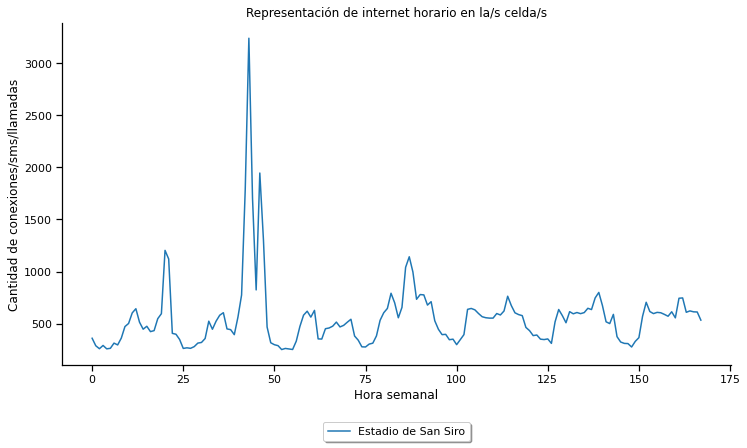

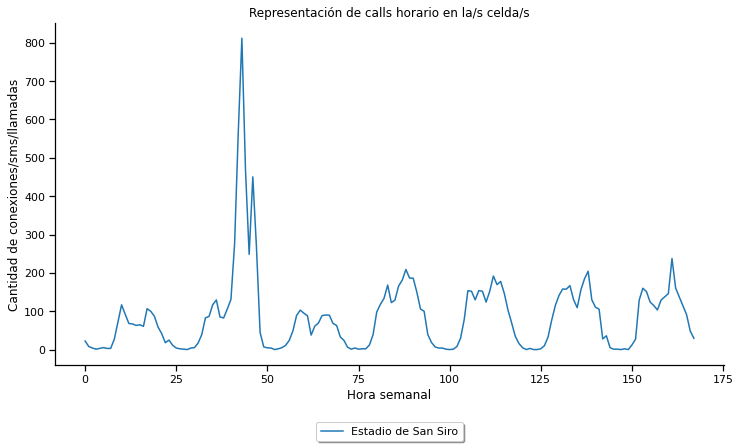

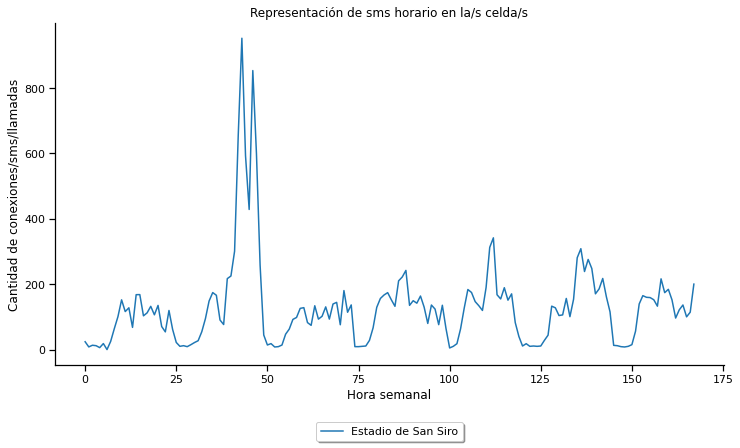

In [10]:
# INTERNET
representa_actividad_celda(df_cdrs,  
                           [5737],
                           ['Estadio de San Siro','ASST Great Metropolitan Niguarda'], 
                           'internet')

# LLAMADAS
representa_actividad_celda(df_cdrs,  
                           [5737],
                           ['Estadio de San Siro','ASST Great Metropolitan Niguarda'], 
                           'calls')

# SMS
representa_actividad_celda(df_cdrs,  
                           [5737],
                           ['Estadio de San Siro','ASST Great Metropolitan Niguarda'], 
                           'sms')

plt.savefig('plot.png', dpi=300, bbox_inches='tight')

In [11]:
df_sansiro = df_cdrs[df_cdrs['CellID'] ==5737].copy()
df_sansiro

,datetime,CellID,internet,calls,callin,callout,sms,smsin,smsout
hour,,,,,,,,,
0.0,2013-11-01 00:00:00,5737,359.7558,22.2815,8.0865,14.1950,23.9100,20.9431,2.9669
1.0,2013-11-01 01:00:00,5737,287.6762,7.9118,2.9669,4.9449,8.0865,7.0975,0.9890
2.0,2013-11-01 02:00:00,5737,259.3452,3.9560,1.9780,1.9780,13.2061,11.2281,1.9780
3.0,2013-11-01 03:00:00,5737,290.6431,0.9890,0.9890,0.0000,11.8677,7.9118,3.9559
4.0,2013-11-01 04:00:00,5737,258.1226,2.9669,0.0000,2.9669,5.9339,1.9780,3.9559
...,...,...,...,...,...,...,...,...,...
163.0,2013-11-07 19:00:00,5737,608.9800,137.6000,63.8185,73.7815,121.5874,84.9953,36.5921
164.0,2013-11-07 20:00:00,5737,622.1860,114.3152,39.0940,75.2212,136.3065,93.7805,42.5260
165.0,2013-11-07 21:00:00,5737,613.3418,91.0449,45.0279,46.0170,100.1203,67.4841,32.6362


In [12]:
df_sansiro['Dates'] = df_sansiro['datetime'].dt.date
df_sansiro['Year'] = df_sansiro['datetime'].dt.year
df_sansiro['Month'] = df_sansiro['datetime'].dt.month
df_sansiro['Week'] = df_sansiro['datetime'].dt.week
df_sansiro['Weekday'] = df_sansiro['datetime'].dt.dayofweek
df_sansiro['WeekdayName'] = df_sansiro['datetime'].dt.day_name()
df_sansiro['DayOfMonth'] = df_sansiro['datetime'].dt.day
df_sansiro['Time'] = df_sansiro['datetime'].dt.time
df_sansiro['HourNumber'] = df_sansiro['datetime'].dt.hour
df_sansiro['DayPart']=pd.cut(df_sansiro['datetime'].dt.hour,
               [4,8,12,16,20],
               labels=['Night','Morning','Afternoon','Evening'],
               include_lowest=True)

C:\Users\jlpad\AppData\Local\Temp/ipykernel_18296/2460895058.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_sansiro['Week'] = df_sansiro['datetime'].dt.week


In [13]:
df_sansiro.describe()

,CellID,internet,calls,callin,callout,sms,smsin,smsout,Year,Month,Week,Weekday,DayOfMonth,HourNumber
count,168.0,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.0,168.0,168.000000,168.000000,168.000000,168.000000
mean,5737.0,555.049583,86.961823,38.157585,48.804237,129.257553,82.164536,47.093017,2013.0,11.0,44.571429,3.000000,4.000000,11.500000
std,0.0,329.900146,103.350377,45.179128,58.875513,134.255038,101.091291,47.431636,0.0,0.0,0.496351,2.005979,2.005979,6.942881
min,5737.0,251.199700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.0,11.0,44.000000,0.000000,1.000000,0.000000
25%,5737.0,356.424125,7.664550,3.955900,4.741325,43.006350,14.151350,15.329125,2013.0,11.0,44.000000,1.000000,2.000000,5.750000
50%,5737.0,523.489000,69.527000,32.403700,39.073100,119.588250,72.902250,32.636200,2013.0,11.0,45.000000,3.000000,4.000000,11.500000
75%,5737.0,613.984425,129.390125,57.096450,71.636025,161.963600,107.259725,54.190150,2013.0,11.0,45.000000,5.000000,6.000000,17.250000
max,5737.0,3239.112400,811.926700,368.403100,443.523600,952.126700,698.511900,253.614800,2013.0,11.0,45.000000,6.000000,7.000000,23.000000


# Análisis exploratorio de datos:

## Analizar una nueva zona de Milán para extraer conclusiones

Vamos a analizar la zona del **estadio de San Siro** cuya celda se puede obtener de la siguiente manera: 

    devuelve_celda_punto(json_data, (9.12400, 45.47889))
    

Se trata de representar la actividad de la celda mediante 3 gráficas similares a las utilizadas anteriormente (para internet, sms y calls)

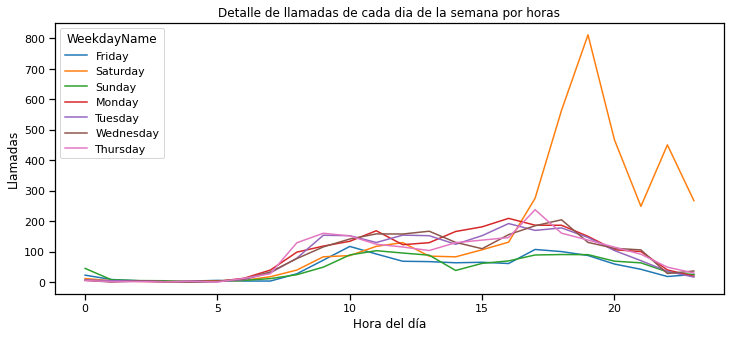

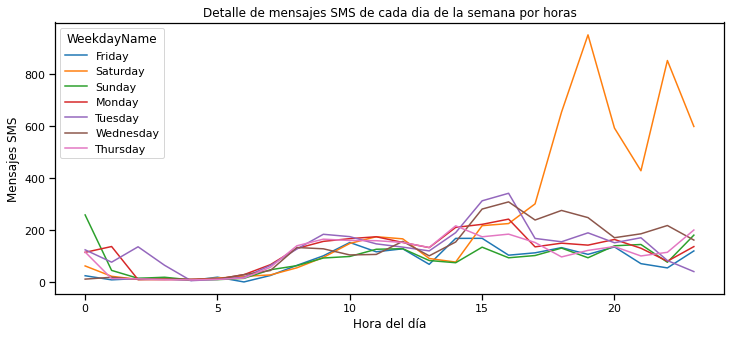

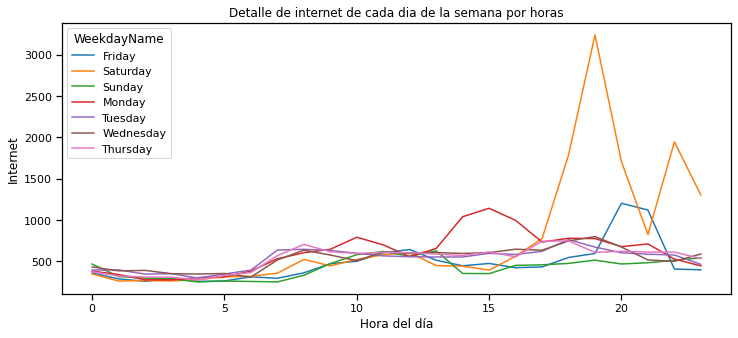

In [14]:
# Detalle de llamadas de cada día de la semana por horas

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='HourNumber', y='calls', color='green', hue='WeekdayName')
plt.title('Detalle de llamadas de cada dia de la semana por horas')
plt.xlabel('Hora del día')
plt.ylabel('Llamadas')
plt.show()

# Detalle de mensajes SMS de cada día de la semana por horas

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='HourNumber', y='sms', color='green', hue='WeekdayName')
plt.title('Detalle de mensajes SMS de cada dia de la semana por horas')
plt.xlabel('Hora del día')
plt.ylabel('Mensajes SMS')
plt.show()

# Detalle de internet de cada día de la semana por horas

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='HourNumber', y='internet', hue='WeekdayName')
plt.title('Detalle de internet de cada dia de la semana por horas')
plt.xlabel('Hora del día')
plt.ylabel('Internet')
plt.show()

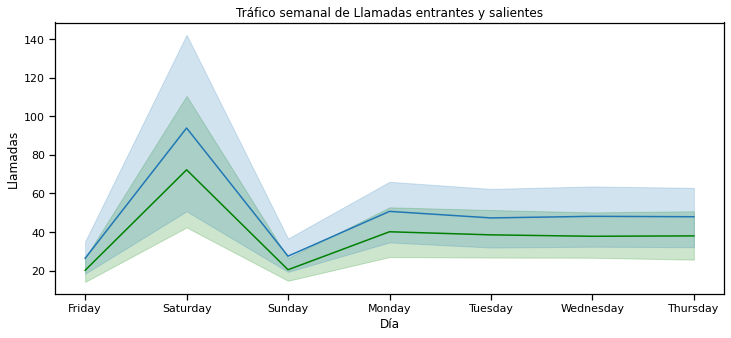

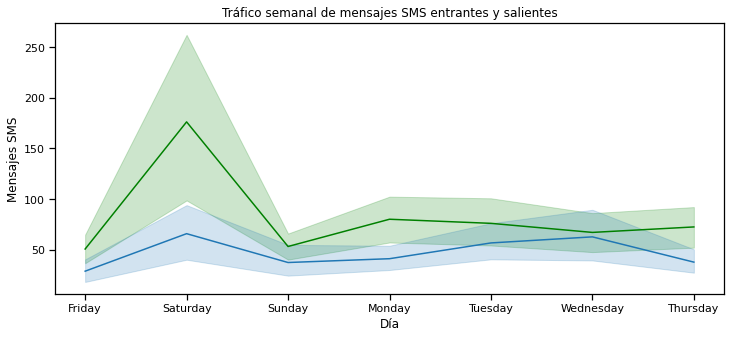

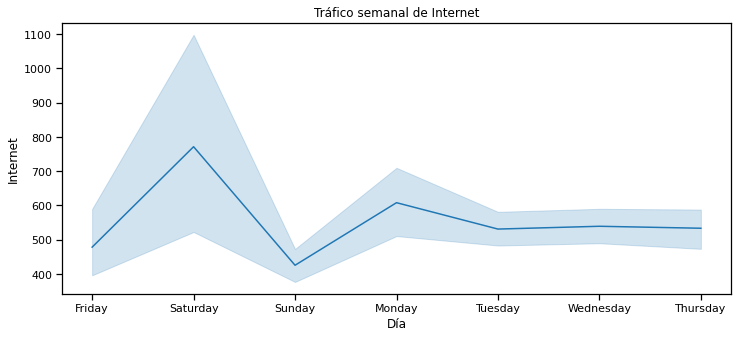

In [15]:
# Tráfico semanal de Llamadas entrantes y salientes.

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='WeekdayName', y='callin', color='green')
sns.lineplot(data=df_sansiro, x='WeekdayName', y='callout')
plt.title('Tráfico semanal de Llamadas entrantes y salientes')
plt.xlabel('Día')
plt.ylabel('Llamadas')
plt.show()

# Tráfico semanal de mensajes SMS entrantes y salientes.

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='WeekdayName', y='smsin', color='green')
sns.lineplot(data=df_sansiro, x='WeekdayName', y='smsout')
plt.title('Tráfico semanal de mensajes SMS entrantes y salientes')
plt.xlabel('Día')
plt.ylabel('Mensajes SMS')
plt.show()

# Tráfico semanal de Internet.
plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='WeekdayName', y='internet')
plt.title('Tráfico semanal de Internet')
plt.xlabel('Día')
plt.ylabel('Internet')
plt.show()

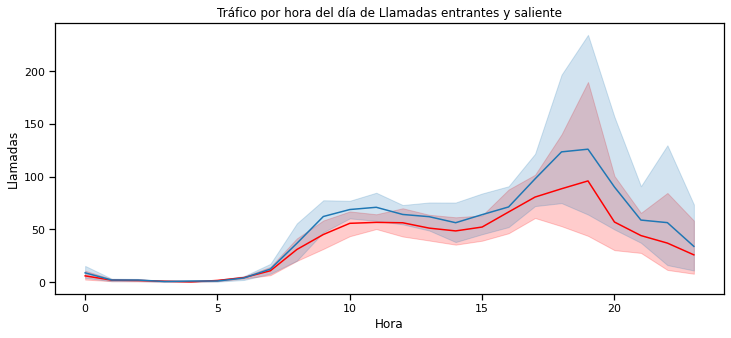

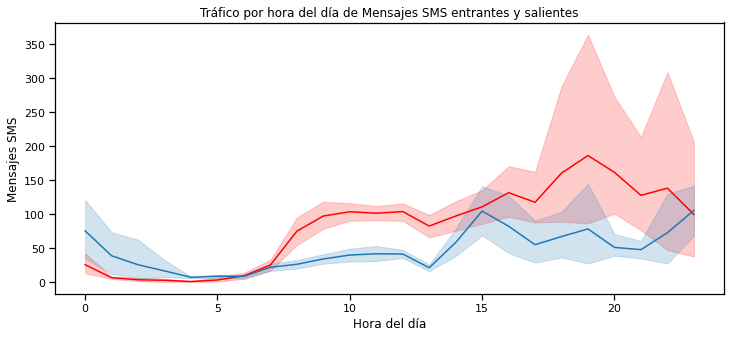

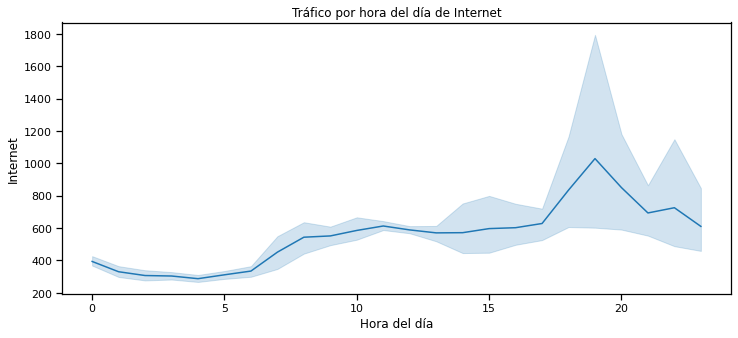

In [16]:
# Tráfico por hora del día de Llamadas entrantes y salientes.

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='HourNumber', y='callin', color='red')
sns.lineplot(data=df_sansiro, x='HourNumber', y='callout')
plt.title('Tráfico por hora del día de Llamadas entrantes y saliente')
plt.xlabel('Hora')
plt.ylabel('Llamadas')
plt.show()

# Tráfico por hora del día de Mensajes SMS entrantes y salientes.

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='HourNumber', y='smsin', color='red')
sns.lineplot(data=df_sansiro, x='HourNumber', y='smsout')
plt.title('Tráfico por hora del día de Mensajes SMS entrantes y salientes')
plt.xlabel('Hora del día')
plt.ylabel('Mensajes SMS')
plt.show()

# Tráfico por hora del día de Ineternet.

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='HourNumber', y='internet')
plt.title('Tráfico por hora del día de Internet')
plt.xlabel('Hora del día')
plt.ylabel('Internet')
plt.show()

1- Vemos que el día sábado es cuando más tráfico en los tres servicios se da 
2- Venis que el horario en el que más tráfico se tiene es en la franja de 16 a 22.

Vamos a centrarnos en analizar los datos del día Sábado.

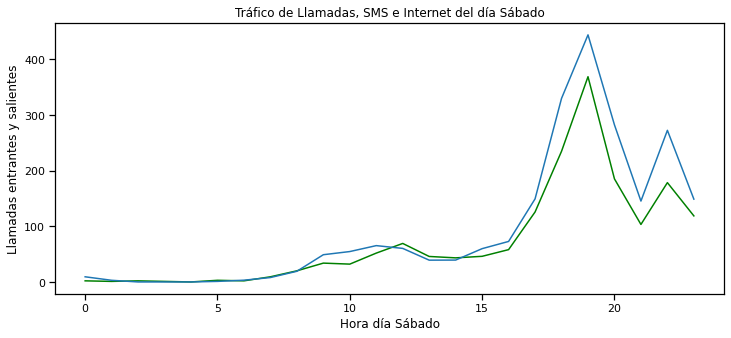

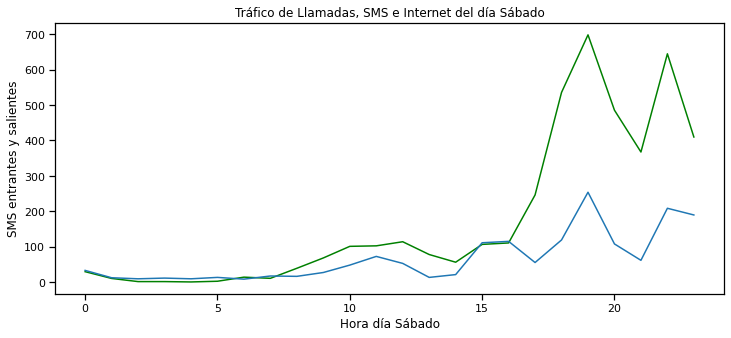

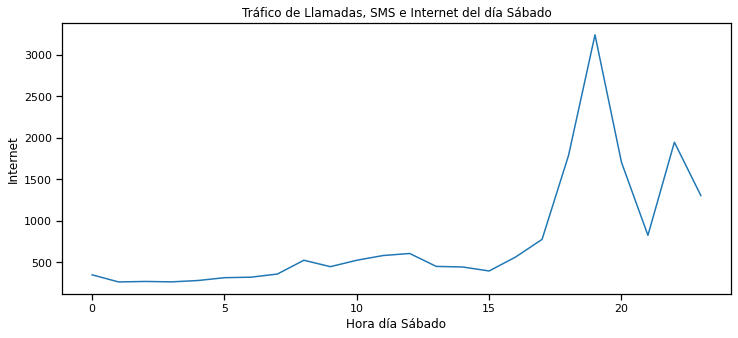

In [17]:
# Tráfico de Llamadas, SMS e Internet del día Sábado

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro[df_sansiro['WeekdayName']=='Saturday'], x='HourNumber', y='callin', color='green')
sns.lineplot(data=df_sansiro[df_sansiro['WeekdayName']=='Saturday'], x='HourNumber', y='callout')
plt.title('Tráfico de Llamadas, SMS e Internet del día Sábado')
plt.xlabel('Hora día Sábado')
plt.ylabel('Llamadas entrantes y salientes')
plt.show()

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro[df_sansiro['WeekdayName']=='Saturday'], x='HourNumber', y='smsin', color='green')
sns.lineplot(data=df_sansiro[df_sansiro['WeekdayName']=='Saturday'], x='HourNumber', y='smsout')
plt.title('Tráfico de Llamadas, SMS e Internet del día Sábado')
plt.xlabel('Hora día Sábado')
plt.ylabel('SMS entrantes y salientes')
plt.show()

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro[df_sansiro['WeekdayName']=='Saturday'], x='HourNumber', y='internet')
plt.title('Tráfico de Llamadas, SMS e Internet del día Sábado')
plt.xlabel('Hora día Sábado')
plt.ylabel('Internet')
plt.show()


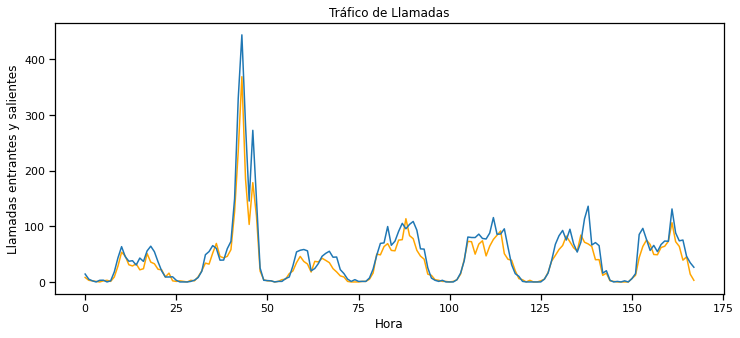

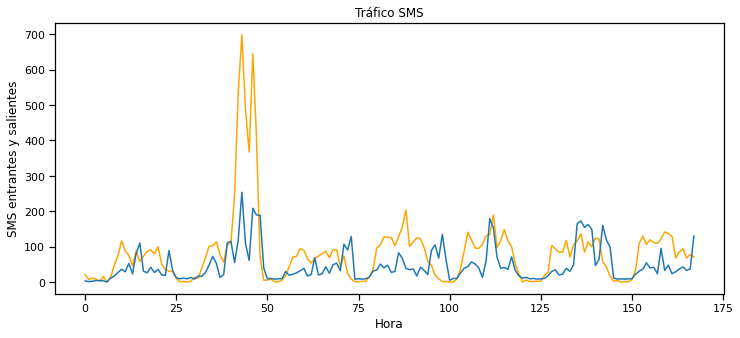

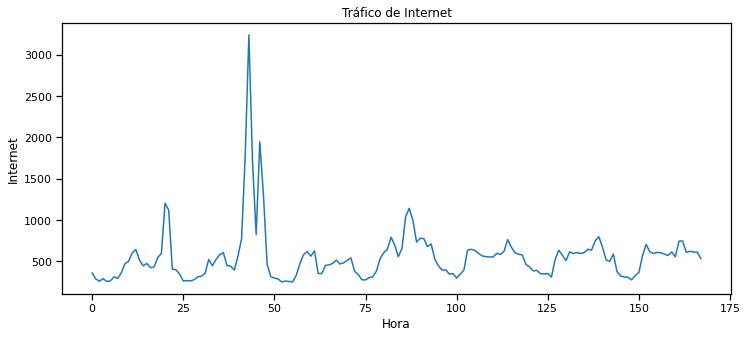

In [18]:

plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='hour', y='callin', color='orange')
sns.lineplot(data=df_sansiro, x='hour', y='callout')
plt.title('Tráfico de Llamadas')
plt.xlabel('Hora')
plt.ylabel('Llamadas entrantes y salientes')
plt.show()


plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='hour', y='smsin', color='orange')
sns.lineplot(data=df_sansiro, x='hour', y='smsout')
plt.title('Tráfico SMS')
plt.xlabel('Hora')
plt.ylabel('SMS entrantes y salientes')
plt.show()


plt.subplots(1, 1, sharex=True)
sns.lineplot(data=df_sansiro, x='hour', y='internet')
plt.title('Tráfico de Internet')
plt.xlabel('Hora')
plt.ylabel('Internet')
plt.show()

# Se pide:
Enviar las respuestas a las siguientes preguntas:

1
¿Qué patrones de consumo se observan en esta zona?

2
¿Qué conclusiones se pueden obtener de las tres gráficas que representan la actividad de las celdas para la zona dada?

**4.5. Análisis de tráfico en celdas de comunicaciones móviles**
Una de las aplicaciones más significativas que tienen la analítica avanzada, la ciencia de datos y el big data en las
empresas de telecomunicaciones es la del análisis del tráfico producido en celdas de comunicaciones
móviles.

Como se comentó en la introducción, las redes móviles son aquellas en las que el último enlace
es inalámbrico vía radio. Los CDR o registros de detalles de llamadas guardan datos de
las llamadas, SMS, internet y cualquier otro contenido consumido por los dispositivos en las
celdas.

Los CDR son un tesoro de información acerca de los usuarios. Van acompañados de metadatos que incluyen,
entre otros datos:
1- Los números de teléfono de las llamadas.
2- La ruta que tomó la llamada para conectarse.
3- Y cualquier condición defectuosa que experimentó la llamada.

Además, es posible obtener los datos de las localizaciones de los dispositivos.

Es importante señalar que las empresas de telecomunicaciones no son las únicas que hacen
uso de estos datos. Muchos datos son utilizados por los estados casi tanto como por las
propias empresas de telecomunicaciones. Existen casos justificados, como delitos, etc. donde
un estado utiliza estos datos.

Gracias a la información proporcionada por los CDR, es posible mejorar la experiencia del cliente. Se pueden
obtener métricas como las pérdidas de paquetes de red, las latencias de red o la calidad de las llamadas.
Uno de los usos muy extendidos es el del análisis del tráfico de red para saber si es necesario o no instalar más
antenas en determinadas circunstancias. En casos en los que se prevé que el tráfico en determinadas celdas va a
ser muy alto, se pueden utilizar más estaciones base para dividir el espacio en celdas más pequeñas que soporten
esa congestión.

Las pérdidas de paquetes de red, latencias y calidad de llamadas también proporcionan insights de qué parte de la
red está repercutiendo más negativamente en la calidad del servicio que se da a los clientes.
Por último, pero no menos importante y significativo, es el uso que se puede dar a las localizaciones para la
creación de productos basados en el flujo de personas que hay en determinados puntos geográficos.

Algunas telecos españolas tienen productos que venden como servicio a pequeñas y medianas empresas en los
que se les permite saber a qué hora, qué cantidad y qué perfil de personas pasan delante de sus establecimientos.